<a href="https://colab.research.google.com/github/maaz1m/long-short-term-memory-network/blob/main/Long_Short_Term_Memory_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: If you are using the Google Colab and want to use tensorflow < 2: you will have to downgrade using this link. https://colab.research.google.com/notebooks/tensorflow_version.ipynb

# Sentiment Analysis using LSTMs

Sentiment analysis is one of the key areas of research in NLP and Sequence modelling. We will be using LSTMs and Bi-directional LSTMs to predict two classes - positive or negative sentiment.


We will be reading the dataset from here: https://drive.google.com/file/d/127PCwycL0oToSF6l-c2oFuBkacYsmlgK/view?usp=sharing

In [ ]:
%tensorflow_version 1.x
import numpy as np 
import pandas as pd 
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Conv1D, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('drive/My Drive/LUMS/CS437/IMDB Dataset.csv')

## Data Cleaning

In [ ]:
# Clean data

import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = stopwords.words('english')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
HTML_TAGS_RE = re.compile('<.{0,10}>')

def clean_text(text):

    text = text.lower()

    text = HTML_TAGS_RE.sub(' ', text) 
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text) 

    whitelist = ['not', 'no']
    blacklist = [w for w in STOPWORDS if w not in whitelist]
    text = ' '.join(word for word in text.split() if word not in blacklist) # remove stopwords from text
    return text
    
df['review'] = df['review'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The data cleaning techniques are as follows:

- Remove all HTML tags from the corpus
- Converted corpus to lower case
- Removed stopwords
 - Kept important stop words like 'not' and 'no'
- Removed bad symbols
- Removed bad characters

## Data Exploration

In [ ]:
# Getting number of distinct tokens

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(lowercase = True, stop_words='english')
vec = cv.fit_transform(df['review'])                                                  
words = cv.get_feature_names()
len(words)

152292

In [ ]:
# Getting minimum length of review

len(min(df['review'], key = len))

17

In [ ]:
# Getting maximum length of review

len(max(df['review'], key = len))

9294

(-0.5, 1599.5, 799.5, -0.5)

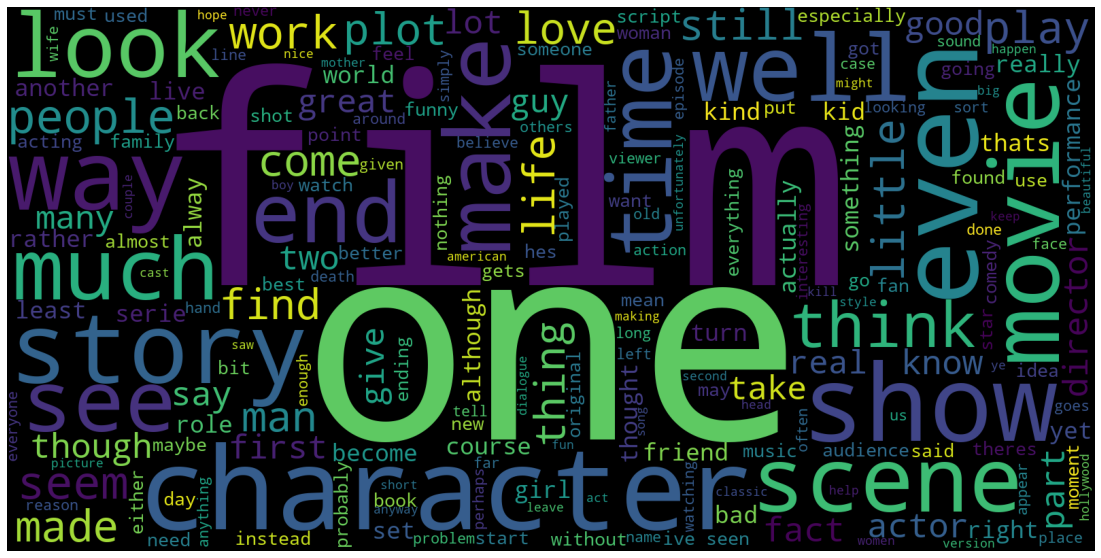

In [ ]:
# Making the wordcloud of most common words

from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=STOPWORDS, width=1600, height=800).generate(' '.join(df['review']))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")

## Model processing

You can use a 70:30 train/test split.
The labels are 'positive' and negative, you should assign them integers 0 or 1 for further processing.

In [ ]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

In [ ]:
# Converting labels to binary

df['sentiment']=df['sentiment'].apply(lambda x: int(x=='positive'))

In [ ]:
# Splitting data to train set and test set

X_train, X_test, Y_train, Y_test = train_test_split(df['review'], df['sentiment'], test_size=0.3)
print('Training data samples:', X_train.shape[0])
print('Test data samples:', X_test.shape[0])

Training data samples: 35000
Test data samples: 15000


## Tokenizer

We will need to use fit a tokenizer over your training and testing data.

A tokenizer creates a dictionary of word to integer mappings. It updates internal vocabulary based on a list of texts.



In [ ]:
# Tokenizing the corpus

tk = Tokenizer(num_words=100000,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")

tk.fit_on_texts(X_train)

In [ ]:
# Converting data to sequence

X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [ ]:
# Padding some sequences to max length

from keras.preprocessing.sequence import pad_sequences

X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=1200)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=1200) 

## Model Engineering

We will be creating three types of models from scratch.

1.   Using LSTMs
2.   Bi-directional LSTMs
3.   A model with less than 10,000 parameters


In [ ]:
# Setting hyperparameters

MAX_NB_WORDS = 100000
EMBEDDING_DIM = 16
NUM_FILTERS = 64
KERNEL_SIZE = 5
POOL_SIZE = 3
EPOCHS = 5
BATCH_SIZE = 1024

In [ ]:
def plot_graphs(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

### LSTM

In [ ]:
# Building the LSTM model

model1 = Sequential()
model1.name = 'lstm'
model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_seq_trunc.shape[1]))
model1.add(Dropout(0.2))
model1.add(Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, padding='same', activation='relu'))
model1.add(MaxPooling1D(POOL_SIZE))
model1.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1200, 16)          1600000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1200, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1200, 64)          5184      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 400, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               212000    
_________________________________________________________________
dense_1 (Dense)   

In [ ]:
# Training the LSTM model

history1 = model1.fit(X_train_seq_trunc, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.1)


Train on 31500 samples, validate on 3500 samples
Epoch 1/5
31500/31500 [==============================] - 23s 730us/step - loss: 0.6747 - accuracy: 0.5680 - val_loss: 0.5382 - val_accuracy: 0.7677
Epoch 2/5
31500/31500 [==============================] - 16s 513us/step - loss: 0.4060 - accuracy: 0.8277 - val_loss: 0.3159 - val_accuracy: 0.8671
Epoch 3/5
31500/31500 [==============================] - 16s 512us/step - loss: 0.2141 - accuracy: 0.9188 - val_loss: 0.2704 - val_accuracy: 0.8937
Epoch 4/5
31500/31500 [==============================] - 16s 515us/step - loss: 0.1313 - accuracy: 0.9530 - val_loss: 0.2939 - val_accuracy: 0.8903
Epoch 5/5
31500/31500 [==============================] - 16s 515us/step - loss: 0.0837 - accuracy: 0.9719 - val_loss: 0.3360 - val_accuracy: 0.8897


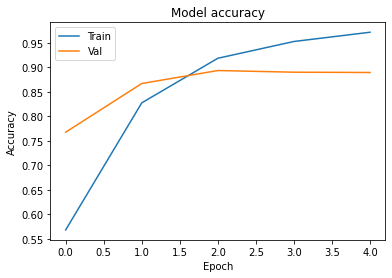

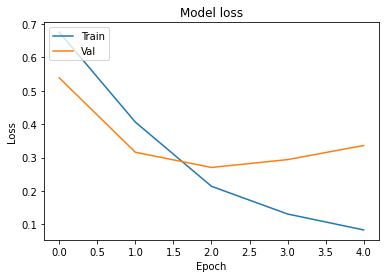

Test accuracy: 0.888866662979126


In [ ]:
# Evaluating the LSTM model

plot_graphs(history1)

score = model1.evaluate(X_test_seq_trunc, Y_test, verbose = 0)
print('Test accuracy:', score[1])

### Bidirectional LSTM

In [ ]:
# Building the bidirectional model

model2 = Sequential()
model2.name = 'bidirectional'
model2.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train_seq_trunc.shape[1]))
model2.add(Dropout(0.2))
model2.add(Conv1D(filters=NUM_FILTERS, kernel_size=KERNEL_SIZE, padding='same', activation='relu'))
model2.add(MaxPooling1D(POOL_SIZE))
model2.add(Bidirectional(LSTM(200, dropout=0.2, recurrent_dropout=0.2)))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1200, 16)          1600000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1200, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1200, 64)          5184      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 400, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               424000    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 2,029,585
Trainable params: 2,029,585
Non-trainable params: 0
___________________________________________

In [ ]:
# Training the bidirectional model

history2 = model2.fit(X_train_seq_trunc, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/5
31500/31500 [==============================] - 29s 910us/step - loss: 0.6868 - accuracy: 0.5521 - val_loss: 0.6499 - val_accuracy: 0.7846
Epoch 2/5
31500/31500 [==============================] - 28s 895us/step - loss: 0.4906 - accuracy: 0.7951 - val_loss: 0.3232 - val_accuracy: 0.8660
Epoch 3/5
31500/31500 [==============================] - 28s 882us/step - loss: 0.2411 - accuracy: 0.9070 - val_loss: 0.2628 - val_accuracy: 0.8960
Epoch 4/5
31500/31500 [==============================] - 28s 883us/step - loss: 0.1527 - accuracy: 0.9451 - val_loss: 0.2664 - val_accuracy: 0.8946
Epoch 5/5
31500/31500 [==============================] - 28s 881us/step - loss: 0.0950 - accuracy: 0.9686 - val_loss: 0.3134 - val_accuracy: 0.8946


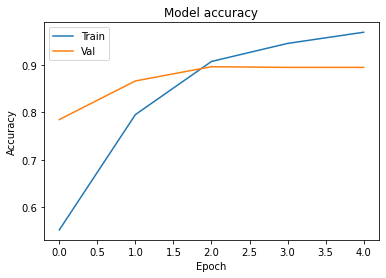

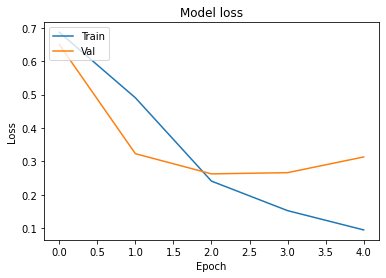

Test accuracy: 0.8955333232879639


In [ ]:
# Evaluating the bidirectional model

plot_graphs(history2)

score = model2.evaluate(X_test_seq_trunc, Y_test, verbose = 0)
print('Test accuracy:', score[1])

### Low parameter model



In [ ]:
# Building the low parameter model (total params: 8,921)

model3 = Sequential()
model3.name = 'low_param'
model3.add(Embedding(1000, 2, input_length=X_train_seq_trunc.shape[1]))
model3.add(Dropout(0.2))
model3.add(LSTM(40, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "low_param"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1200, 2)           2000      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1200, 2)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                6880      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 41        
Total params: 8,921
Trainable params: 8,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the low parameter model

history3 = model3.fit(X_train_seq_trunc, Y_train, epochs=10, batch_size=BATCH_SIZE, validation_split=0.1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/10
31500/31500 [==============================] - 43s 1ms/step - loss: 0.6927 - accuracy: 0.5141 - val_loss: 0.6910 - val_accuracy: 0.6623
Epoch 2/10
31500/31500 [==============================] - 44s 1ms/step - loss: 0.6819 - accuracy: 0.6087 - val_loss: 0.6566 - val_accuracy: 0.7540
Epoch 3/10
31500/31500 [==============================] - 43s 1ms/step - loss: 0.6288 - accuracy: 0.7200 - val_loss: 0.5481 - val_accuracy: 0.7969
Epoch 4/10
31500/31500 [==============================] - 43s 1ms/step - loss: 0.5475 - accuracy: 0.7494 - val_loss: 0.4769 - val_accuracy: 0.7617
Epoch 5/10
31500/31500 [==============================] - 43s 1ms/step - loss: 0.5180 - accuracy: 0.7587 - val_loss: 0.4490 - val_accuracy: 0.8123
Epoch 6/10
31500/31500 [==============================] - 43s 1ms/step - loss: 0.4884 - accuracy: 0.7723 - val_loss: 0.3981 - val_accuracy: 0.8311
Epoch 7/10
31500/31500 [==============================] - 43s 1ms/ste

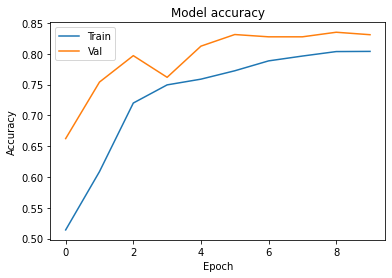

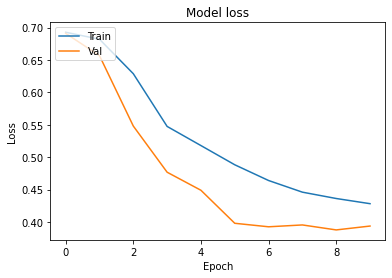

Test accuracy: 0.8205333352088928


In [ ]:
# Evaluating the low parameter model

plot_graphs(history3)

score = model3.evaluate(X_test_seq_trunc, Y_test, verbose = 0)
print('Test accuracy:', score[1])

## Model Predictions


In [ ]:
# Predicting on new reviews using the bidirectional model

new_reviews = ['This was a good movie', 'This was an ok movie', 'Idk what this was, it made no sense', 'A work of art I tell you', 'I expect an oscar sweep for this movie', 'SRK never fails to disappoint', 'An absolute nightmare. I want 3 hours of my life back.', 'Good acting manages to cover for gaping plot holes', 'Despite state-of-the-art cinematography, poor character development will leave this film forever mired in mediocrity', 'This was meh. Jaws 1 was better.']
seq = tk.texts_to_sequences(new_reviews)
padded = pad_sequences(seq, maxlen=1200)
pred = model2.predict(padded)

for i in range(len(new_reviews)):
    sent = 'positive' if pred[i]>0.5 else 'negative'
    print('"%s" has a %s sentiment.' % (new_reviews[i], sent))

"This was a good movie" has a positive sentiment.
"This was an ok movie" has a negative sentiment.
"Idk what this was, it made no sense" has a negative sentiment.
"A work of art I tell you" has a positive sentiment.
"I expect an oscar sweep for this movie" has a positive sentiment.
"SRK never fails to disappoint" has a negative sentiment.
"An absolute nightmare. I want 3 hours of my life back." has a negative sentiment.
"Good acting manages to cover for gaping plot holes" has a negative sentiment.
"Despite state-of-the-art cinematography, poor character development will leave this film forever mired in mediocrity" has a negative sentiment.
"This was meh. Jaws 1 was better." has a negative sentiment.
